In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from keras import Input, Model, layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
def time_step(data, ts, lag, duration):
    dataX = []
    dataY = []
    
    for i in range(len(data)-ts-(lag-1)-(duration-1)):
        dataX.append(data[i:i+ts])
        dataY.append(data[i+ts+lag-1:i+ts+lag-1+duration])
        
    dataX = np.array(dataX)
    dataY = np.array(dataY)  

    return dataX, dataY

def normalization(data_train, data_val, data_test):
    scaler = MinMaxScaler()
    scaler.fit(data_train)
    
    n_data_train = scaler.transform(data_train)
    n_data_val = scaler.transform(data_val)
    n_data_test = scaler.transform(data_test)
    
    return n_data_train, n_data_val, n_data_test

In [3]:
# 데이터 불러오기

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

df = pd.read_csv(url)

In [4]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,55714,55733,55759,55770,55775,55827,55840,55847,55876,55876
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,107167,107931,108823,109674,110521,111301,112078,112897,113580,114209
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,113092,113255,113430,113593,113761,113948,114104,114234,114382,114543
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,10866,10889,10908,10948,10976,10998,11019,11042,11069,11089
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,20807,20854,20882,20923,20981,21026,21055,21086,21108,21114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,2448,2448,2475,2482,2488,2494,2501,2512,2524,2526
270,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,183612,185336,187309,189326,191203,193029,194548,196812,198554,200382
271,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2285,2310,2342,2363,2375,2411,2444,2473,2545,2586
272,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,78534,79002,79557,80090,80687,81341,82011,82421,82655,82897


In [5]:
# 한국의 누적 확진자수를 일일 신규 확진자수로 변경

df = df[df['Country/Region'] == 'Korea, South']
df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace=True)

C:\Users\PC\.conda\envs\tf115\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21
158,1,1,2,2,3,4,4,4,4,11,...,90031,90372,90816,91240,91638,92055,92471,92817,93263,93733


In [7]:
df = df.T
df.columns = ['Confirmed']
df.index = pd.to_datetime(df.index)

data = []
for index, value in enumerate(df['Confirmed']):
    if index == 0:
        data.append(value)
    else:
        data.append(value - df['Confirmed'].iloc[index-1])

In [8]:
data

[1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 7,
 1,
 3,
 0,
 1,
 3,
 4,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 73,
 100,
 229,
 169,
 231,
 144,
 284,
 505,
 571,
 813,
 586,
 599,
 851,
 435,
 467,
 505,
 448,
 273,
 164,
 35,
 242,
 114,
 110,
 107,
 76,
 74,
 84,
 93,
 152,
 87,
 147,
 162,
 0,
 76,
 100,
 104,
 91,
 146,
 105,
 78,
 125,
 101,
 89,
 86,
 94,
 81,
 47,
 47,
 53,
 39,
 27,
 30,
 32,
 25,
 27,
 27,
 22,
 22,
 18,
 8,
 13,
 9,
 11,
 14,
 10,
 10,
 10,
 14,
 9,
 4,
 9,
 6,
 13,
 8,
 3,
 2,
 4,
 12,
 18,
 34,
 35,
 27,
 26,
 29,
 27,
 19,
 13,
 15,
 13,
 32,
 12,
 20,
 23,
 25,
 16,
 19,
 40,
 79,
 58,
 39,
 27,
 35,
 38,
 49,
 39,
 39,
 51,
 57,
 38,
 38,
 50,
 45,
 56,
 48,
 34,
 36,
 34,
 43,
 59,
 49,
 67,
 48,
 17,
 46,
 51,
 28,
 39,
 51,
 62,
 42,
 43,
 50,
 54,
 63,
 63,
 61,
 46,
 44,
 63,
 49,
 45,
 35,
 44,
 62,
 33,
 39,
 61,
 60,
 39,
 34,
 26,
 45,
 63,
 59,
 41,
 113,
 58,
 25,
 28,
 48,
 18,
 36,
 31,
 30,
 23,
 34,
 33,
 43,
 20,
 43,
 36,
 28,
 34

In [9]:
from tensorflow.python.client import device_lib

In [10]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9848369034367528883,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3141979342
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14913618067755620310
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [78]:
# Sub model 1 - DNN

rmse = []
r2 = []

for ts in range(3, 11, 1):  
    
    # time step & lag
    data_X, data_Y = time_step(data , ts, 1, 1)
    
    # 데이터 분할
    NUM_TRAIN = int(data_X.shape[0] * 0.6)
    NUM_VAL = int(data_X.shape[0] * 0.8)

    train_X = data_X[:NUM_TRAIN]
    train_Y = data_Y[:NUM_TRAIN]

    val_X = data_X[NUM_TRAIN:NUM_VAL]
    val_Y = data_Y[NUM_TRAIN:NUM_VAL]

    test_X = data_X[NUM_VAL:]
    test_Y =data_Y[NUM_VAL:]

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    # 함수형 API
    input_tensor = Input(shape=(train_X.shape[1],))
    x = layers.Dense(16, activation='relu')(input_tensor)
    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dense(4, activation='relu')(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)

    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('C:/Users/PC/Desktop/model/DNN/model_{}.h5'.format(ts), monitor='val_loss', save_best_only=True)

    model.fit(train_X, train_Y,
              batch_size=8,
              epochs=10000,
              validation_data=(val_X, val_Y),
              callbacks=[early_stopping, mc],
              shuffle=False,
              verbose=0)
    
    best_model = load_model('C:/Users/PC/Desktop/model/DNN/model_{}.h5'.format(ts))
    
    y_pred = best_model.predict(test_X)
    y_pred = y_pred.reshape(-1).astype('float32')
    y_real = test_Y.reshape(-1).astype('float32')
    
    raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
    rr = pd.DataFrame(raw)
#     rr.to_csv("./Submodel/DNN/time_step/timse_step{}.csv".format(ts))
    reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

    try:
        RMSE = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
        R2 = round(reg.rsquared, 3)   
    except ValueError:
        pass
    
    rmse.append(RMSE)
    r2.append(R2)
#     plt.figure(figsize=(10, 8))
#     plt.plot(test_Y, label='Observed')
#     plt.plot(y_predict, label='Predicted')
#     plt.legend()
#     plt.savefig('fig_{}.png'.format(ts), dpi=300)
 
    del model

InternalError: GPU sync failed

In [11]:
# Sub model 2 - LSTM

rmse = []
r2 = []
for ts in range(3, 11, 1):  
    
    # Time step과 MinMax 정규화
    train_X, train_Y = time_step(df_train, ts, 1, 1)
    val_X, val_Y = time_step(df_val, ts, 1, 1)
    test_X, test_Y = time_step(df_test, ts, 1, 1)

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    # 함수형 API
    input_tensor = Input(shape=(train_X.shape[1],))
    x = layers.Reshape((train_X.shape[1], 1))(input_tensor)
    x = layers.LSTM(32, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(16, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(8, activation='relu', return_sequences=True)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4, activation='relu')(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)

    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/LSTM/model_{}.h5'.format(ts), monitor='val_loss', save_best_only=True)
    
    model.fit(train_X, train_Y,
              batch_size=8,
              epochs=1000,
              shuffle=False,
              validation_data=(val_X, val_Y),
              callbacks=[early_stopping, mc],
              verbose=0)
    
    best_model = load_model('./model/LSTM/model_{}.h5'.format(ts))
    
    y_pred = best_model.predict(test_X)
    y_pred = y_pred.reshape(-1).astype('float32')
    y_real = test_Y.reshape(-1).astype('float32')
    
    raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
    rr = pd.DataFrame(raw)
#     rr.to_csv("./Submodel/DNN/time_step/timse_step{}.csv".format(ts))
    reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

    try:
        RMSE = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
        R2 = round(reg.rsquared, 3)   
    except ValueError:
        pass
    
    rmse.append(RMSE)
    r2.append(R2)
#     plt.figure(figsize=(10, 8))
#     plt.plot(test_Y, label='Observed')
#     plt.plot(y_predict, label='Predicted')
#     plt.legend()
#     plt.savefig('fig_{}.png'.format(ts), dpi=300)
 
    del model

NameError: name 'df_train' is not defined

In [117]:
# Sub model 3 - GRU

rmse = []
r2 = []
for ts in range(3, 11, 1):  
    
    # Time step과 MinMax 정규화
    train_X, train_Y = time_step(df_train, ts, 1, 1)
    val_X, val_Y = time_step(df_val, ts, 1, 1)
    test_X, test_Y = time_step(df_test, ts, 1, 1)

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    # 함수형 API
    input_tensor = Input(shape=(train_X.shape[1],))
    x = layers.Reshape((train_X.shape[1], 1))(input_tensor)
    x = layers.GRU(32, activation='relu', return_sequences=True)(x)
    x = layers.GRU(16, activation='relu', return_sequences=True)(x)
    x = layers.GRU(8, activation='relu', return_sequences=True)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4, activation='relu')(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)

    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/GRU/model_{}.h5'.format(ts), monitor='val_loss', save_best_only=True)
    
    model.fit(train_X, train_Y,
              batch_size=8,
              epochs=1000,
              shuffle=False,
              validation_data=(val_X, val_Y),
              callbacks=[early_stopping, mc],
              verbose=0)
    
    best_model = load_model('./model/GRU/model_{}.h5'.format(ts))
    
    y_pred = best_model.predict(test_X)
    y_pred = y_pred.reshape(-1).astype('float32')
    y_real = test_Y.reshape(-1).astype('float32')
    
    raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
    rr = pd.DataFrame(raw)
#     rr.to_csv("./Submodel/DNN/time_step/timse_step{}.csv".format(ts))
    reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

    try:
        RMSE = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
        R2 = round(reg.rsquared, 3)   
    except ValueError:
        pass
    
    rmse.append(RMSE)
    r2.append(R2)
#     plt.figure(figsize=(10, 8))
#     plt.plot(test_Y, label='Observed')
#     plt.plot(y_predict, label='Predicted')
#     plt.legend()
#     plt.savefig('fig_{}.png'.format(ts), dpi=300)
 
    del model

In [120]:
# Sub model 4 - CNN

rmse = []
r2 = []
for ts in range(3, 11, 1):  
    
    # Time step과 MinMax 정규화
    train_X, train_Y = time_step(df_train, ts, 1, 1)
    val_X, val_Y = time_step(df_val, ts, 1, 1)
    test_X, test_Y = time_step(df_test, ts, 1, 1)

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    # 함수형 API
    input_tensor = Input(shape=(train_X.shape[1],))
    x = layers.Reshape((1, train_X.shape[1], 1))(input_tensor)
    x = layers.Conv2D(16, kernel_size=(1,2), padding='same', activation='relu')(x)
    x = layers.Conv2D(8, kernel_size=(1,2), padding='same', activation='relu')(x)
    x = layers.Conv2D(4, kernel_size=(1,2), padding='valid', activation='relu')(x)
    x = layers.Flatten()(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)

    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/CNN/model_{}.h5'.format(ts), monitor='val_loss', save_best_only=True)
    
    model.fit(train_X, train_Y,
              batch_size=8,
              epochs=1000,
              shuffle=False,
              validation_data=(val_X, val_Y),
              callbacks=[early_stopping, mc],
              verbose=0)
    
    best_model = load_model('./model/CNN/model_{}.h5'.format(ts))
    
    y_pred = best_model.predict(test_X)
    y_pred = y_pred.reshape(-1).astype('float32')
    y_real = test_Y.reshape(-1).astype('float32')
    
    raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
    rr = pd.DataFrame(raw)
#     rr.to_csv("./Submodel/DNN/time_step/timse_step{}.csv".format(ts))
    reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

    try:
        RMSE = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
        R2 = round(reg.rsquared, 3)   
    except ValueError:
        pass
    
    rmse.append(RMSE)
    r2.append(R2)
#     plt.figure(figsize=(10, 8))
#     plt.plot(test_Y, label='Observed')
#     plt.plot(y_predict, label='Predicted')
#     plt.legend()
#     plt.savefig('fig_{}.png'.format(ts), dpi=300)
 
    del model

In [130]:
num = 0
list = [93.288, 90.605, 94.171, 102.917, 105.200, 109.993, 109.535, 121.036]
rmse_std = []
for ts in range(3, 11, 1):
    train_X, train_Y = time_step(df_train, ts, 1, 1)
    val_X, val_Y = time_step(df_val, ts, 1, 1)
    test_X, test_Y = time_step(df_test, ts, 1, 1)

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    std = test_Y.std()
    rmse = list[num]
    rmse_std.append(round(rmse/std,3))
    num+=1

In [132]:
round((87.955+149.424+446.640+93.288)/4, 3)

194.327

In [133]:
round((92.797+164.735+116.993+90.605)/4, 3)

116.283

In [134]:
round((95.573+179.790+172.149+94.171)/4, 3)

135.421

In [135]:
round((99.656+220.708+105.562+102.917)/4, 3)

132.211

In [136]:
round((104.876+191.899+461.104+105.200)/4, 3)

215.77

In [137]:
round((111.985+253.746+421.202+109.993)/4, 3)

224.231

In [138]:
round((119.072+468.490+252.601+109.535)/4, 3)

237.424

In [139]:
round((138.896+355.465+472.609+121.036)/4, 3)

272.002

In [140]:
model = load_model('./model/DNN/model_4.h5')

In [142]:
model.summary()

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_157 (Dense)            (None, 16)                80        
_________________________________________________________________
dense_158 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_159 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_160 (Dense)            (None, 1)                 5         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Staking Ensemble
# 모델 불러오기

def load_all_models(n):
    all_models = list()
    model_list = ['DNN', 'LSTM', 'GRU', 'CNN']
    for i in range(n):
        filename = './model/{}/model_{}.h5'.format(model_list[i], 4)
        model = load_model(filename)
        all_models.append(model)
        print('>loaded %s' % filename)
    print('\n>complete loading')
    return all_models

In [15]:
all_model = load_all_models(4)

>loaded ./model/DNN/model_4.h5
>loaded ./model/LSTM/model_4.h5
>loaded ./model/GRU/model_4.h5
>loaded ./model/CNN/model_4.h5

>complete loading


In [61]:
def define_stacked_model(members, train, val):
    num = 1
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer.name = 'ensemble_' + str(num) + '_' + layer.name
            num += 1
    
    ensemble_inputs = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]

    merge = layers.concatenate(ensemble_outputs)
    hidden = layers.Dense(10, activation = 'relu')(merge)
    hidden = layers.Dense(4, activation = 'relu')(hidden)
    output_tensor = layers.Dense(1)(hidden)
    
    model = Model(ensemble_inputs, output_tensor)

    # compile
    model.compile(loss='mse', optimizer='adam')
    
    print('훈련 가능한 층(가중치, 편향) :',len(model.trainable_weights))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/ensembel.h5', monitor='val_loss', save_best_only=True)
    
    train_X, train_Y = train
    val_X, val_Y = val 
    
    model.fit([train_X, train_X, train_X, train_X], train_Y, 
              epochs=10000, 
              verbose=0,
              validation_data=([val_X, val_X, val_X, val_X], val_Y),
              batch_size=8,
              shuffle=False,
              callbacks=[early_stopping, mc])
    
    model = load_model('./model/ensembel.h5')
    
    return model

In [52]:
# Time step과 MinMax 정규화
train_X, train_Y = time_step(df_train, 4, 1, 1)
val_X, val_Y = time_step(df_val, 4, 1, 1)
test_X, test_Y = time_step(df_test, 4, 1, 1)

train_X, val_X, test_X = normalization(train_X, val_X, test_X)
train = [train_X, train_Y]
val = [val_X, val_Y]

In [62]:
model = define_stacked_model(all_model, train, val)

훈련 가능한 층(가중치, 편향) : 6


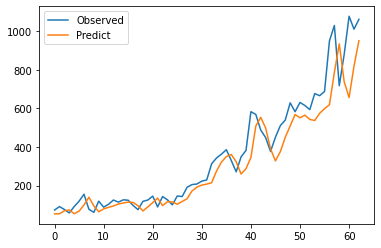

In [63]:
#예측시도
y_pred = model.predict([test_X, test_X, test_X, test_X])
y_pred = y_pred.reshape(-1).astype('float32')
y_real = test_Y.reshape(-1).astype('float32')

raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
rr = pd.DataFrame(raw)
reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

rmse = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
r2 = round(reg.rsquared, 3)   

plt.plot(y_real, label = 'Observed')
plt.plot(y_pred, label = 'Predict')
plt.legend()
plt.show()

In [64]:
rmse, r2

(105.985, 0.911)

In [65]:
for i in model.layers:
    i.trainable = True
    
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [66]:
print('훈련 가능한 층(가중치, 편향) :',len(model.trainable_weights))

훈련 가능한 층(가중치, 편향) : 48


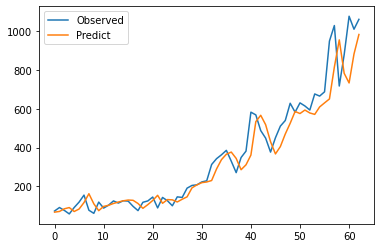

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 15)
mc = ModelCheckpoint('./model/ensembel_full.h5', monitor='val_loss', save_best_only=True)

model.fit([train_X, train_X, train_X, train_X], train_Y, 
          epochs=10000, 
          verbose=0,
          validation_data=([val_X, val_X, val_X, val_X], val_Y),
          batch_size=8,
          shuffle=False,
          callbacks=[early_stopping, mc])

model = load_model('./model/ensembel_full.h5')
y_pred = model.predict([test_X, test_X, test_X, test_X])
y_pred = y_pred.reshape(-1).astype('float32')
y_real = test_Y.reshape(-1).astype('float32')

raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
rr = pd.DataFrame(raw)
reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

rmse = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
r2 = round(reg.rsquared, 3)   

plt.plot(y_real, label = 'Observed')
plt.plot(y_pred, label = 'Predict')
plt.legend()
plt.show()

In [69]:
rmse, r2

(90.685, 0.921)

In [71]:
round(105.985/test_Y.std(), 3)

0.366

In [72]:
round(90.685/test_Y.std(), 3)

0.313